In [3]:
import pandas as pd
from sklearn import linear_model,metrics
from sklearn.pipeline import make_pipeline
from joblib import dump, load
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import math

# Read Data from Results

In [4]:
#Read in the Training DataSet for Effective Volts
df_PreSSD = pd.read_csv('Data/PreSSD_EVs.csv')

train_time = df_PreSSD.index.size*2
df_PreSSD.index=range(0,train_time,2)
time=df_PreSSD.index

#Calculate applied amps and create a new columns
df_PreSSD['App_Amps'] = df_PreSSD.apply(lambda row: row.A1 + row.A2 + row.A3+ row.A4+ row.A5+ row.A6+ row.A7+ 
                                        row.A8+ row.A9+ row.A10+ row.A11+ row.A12+ row.A13+ row.A14, axis=1)

#caluculate coulombs and create a new column
df_PreSSD['Coulombs'] = df_PreSSD['App_Amps'].mul(2).cumsum()

#Caluclate the total effective voltage at each instance
df_PreSSD['Total_Volts'] = df_PreSSD.apply(lambda row: row.Front_V + row.Roof_V + row.RHWing_V + 
                                               row.LHWing_V+ row.Rear_V, axis=1)

#Calculate the Effective Amps on a panel from ratio of Effective volt on the panel to the total effective volts
df_PreSSD['Front_A']= df_PreSSD.apply(lambda row: (row.App_Amps * row.Front_V) / (row.Total_Volts+1),axis=1)
df_PreSSD['Roof_A']= df_PreSSD.apply(lambda row: (row.App_Amps * row.Roof_V) / (row.Total_Volts+1),axis=1)
df_PreSSD['RHWing_A']= df_PreSSD.apply(lambda row: (row.App_Amps * row.RHWing_V) / (row.Total_Volts+1),axis=1)
df_PreSSD['LHWing_A']= df_PreSSD.apply(lambda row: (row.App_Amps * row.LHWing_V) / (row.Total_Volts+1),axis=1)
df_PreSSD['Rear_A']= df_PreSSD.apply(lambda row: (row.App_Amps * row.Rear_V) / (row.Total_Volts+1),axis=1)

print('Training Dataset: \n',df_PreSSD.head())

#Read in the Validation DataSet for Effective Volts
df_PostSSD = pd.read_csv('Data/PostSSD_EVs.csv')

test_time = df_PostSSD.index.size*2
df_PostSSD.index=range(0,test_time,2)

#Calculate applied amps and create a new columns
df_PostSSD['App_Amps'] = df_PostSSD.apply(lambda row: row.A1 + row.A2 + row.A3+ row.A4+ row.A5+ row.A6+ row.A7+ 
                                        row.A8+ row.A9+ row.A10+ row.A11+ row.A12+ row.A13+ row.A14, axis=1)

#caluculate coulombs and create a new column
df_PostSSD['Coulombs'] = df_PostSSD['App_Amps'].mul(2).cumsum()

#Caluclate the total effective voltage at each instance
df_PostSSD['Total_Volts'] = df_PostSSD.apply(lambda row: row.Front_V + row.Roof_V + row.RHWing_V + 
                                               row.LHWing_V+ row.Rear_V, axis=1)

#Calculate the Effective Amps on a panel from ratio of Effective volt on the panel to the total effective volts
df_PostSSD['Front_A']= df_PostSSD.apply(lambda row: (row.App_Amps * row.Front_V) / (row.Total_Volts+1),axis=1)
df_PostSSD['Roof_A']= df_PostSSD.apply(lambda row: (row.App_Amps * row.Roof_V) / (row.Total_Volts+1),axis=1)
df_PostSSD['RHWing_A']= df_PostSSD.apply(lambda row: (row.App_Amps * row.RHWing_V) / (row.Total_Volts+1),axis=1)
df_PostSSD['LHWing_A']= df_PostSSD.apply(lambda row: (row.App_Amps * row.LHWing_V) / (row.Total_Volts+1),axis=1)
df_PostSSD['Rear_A']= df_PostSSD.apply(lambda row: (row.App_Amps * row.Rear_V) / (row.Total_Volts+1),axis=1)

print('Validation Dataset: \n',df_PostSSD.head())


Training Dataset: 
    V1  A1  V2  A2  V3  A3  V4  A4  V5  A5  ...  LHWing_V  Rear_V  App_Amps  \
0   0   0   0   0   0   0   0   0   0   0  ...       0.0     0.0       0.0   
2   0   0   0   0   0   0   0   0   0   0  ...       0.0     0.0       0.0   
4   0   0   0   0   0   0   0   0   0   0  ...       0.0     0.0       0.0   
6   0   0   0   0   0   0   0   0   0   0  ...       0.0     0.0       0.0   
8   0   0   0   0   0   0   0   0   0   0  ...       0.0     0.0       0.0   

   Coulombs  Total_Volts  Front_A  Roof_A  RHWing_A  LHWing_A  Rear_A  
0       0.0          0.0      0.0     0.0       0.0       0.0     0.0  
2       0.0          0.0      0.0     0.0       0.0       0.0     0.0  
4       0.0          0.0      0.0     0.0       0.0       0.0     0.0  
6       0.0          0.0      0.0     0.0       0.0       0.0     0.0  
8       0.0          0.0      0.0     0.0       0.0       0.0     0.0  

[5 rows x 41 columns]
Validation Dataset: 
    V1  A1  V2  A2   V3  A3   V4  A

# Extract Features & Targets for Training & Validation Data set

In [5]:
# xtrain = Features for Training [Total_Applied_Amps, Coulombs]

#Separate out the features Applied [Amps, Coulombs] for the training DataSet
df_xtrain=df_PreSSD[['App_Amps','Coulombs']]
df_xtrain.index = df_PreSSD.index

print('df_xtrain:',df_xtrain.head())

# ytrain = Targets for Training [Front_A,Roof_A,RHWing_A,LHWing_A,Rear_A]
df_ytrain=df_PreSSD.loc[:,'Front_A':'Rear_A']
print('df_ytrain',df_ytrain.head())


# xtest = Features for Validation [Total_Applied_Amps, Coulombs]
df_PostSSD['App_Amps'] = df_PostSSD.apply(lambda row: row.A1 + row.A2 + row.A3+ row.A4+ row.A5+ row.A6+ row.A7+ 
                                        row.A8+ row.A9+ row.A10+ row.A11+ row.A12+ row.A13+ row.A14, axis=1)


#Separate out the features Applied [Amps, Coulombs] for the validation DataSet
df_xtest=df_PostSSD[['App_Amps','Coulombs']]
df_xtest.index = df_PostSSD.index

print('df_xtest:',df_xtest.head())

# ytest = Targets for Validation [Front_A,Roof_A,RHWing_A,LHWing_A,Rear_A]
df_ytest=df_PostSSD.loc[:,'Front_A':'Rear_A']
print('df_ytest',df_ytest.head())


df_xtrain:    App_Amps  Coulombs
0       0.0       0.0
2       0.0       0.0
4       0.0       0.0
6       0.0       0.0
8       0.0       0.0
df_ytrain    Front_A  Roof_A  RHWing_A  LHWing_A  Rear_A
0      0.0     0.0       0.0       0.0     0.0
2      0.0     0.0       0.0       0.0     0.0
4      0.0     0.0       0.0       0.0     0.0
6      0.0     0.0       0.0       0.0     0.0
8      0.0     0.0       0.0       0.0     0.0
df_xtest:    App_Amps  Coulombs
0       0.0       0.0
2       0.0       0.0
4       0.0       0.0
6       0.0       0.0
8       0.0       0.0
df_ytest    Front_A  Roof_A  RHWing_A  LHWing_A  Rear_A
0      0.0     0.0       0.0       0.0     0.0
2      0.0     0.0       0.0       0.0     0.0
4      0.0     0.0       0.0       0.0     0.0
6      0.0     0.0       0.0       0.0     0.0
8      0.0     0.0       0.0       0.0     0.0


# Visualise Training and Validation data sets

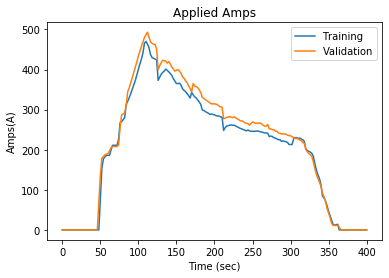

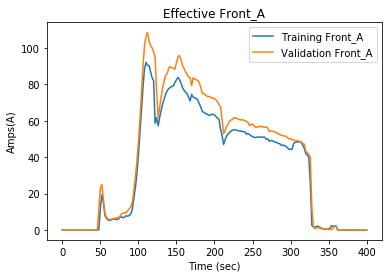

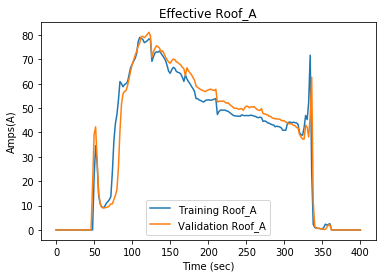

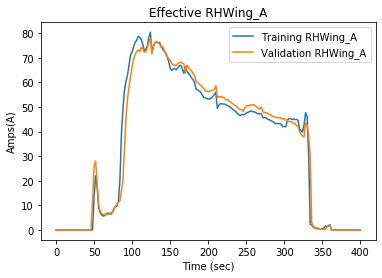

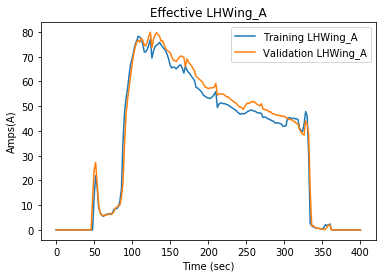

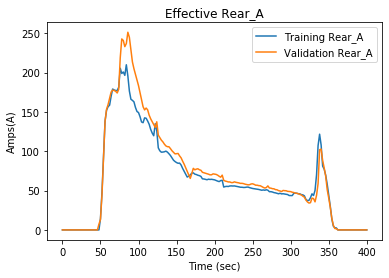

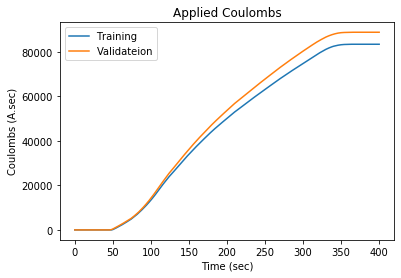

In [9]:
#Plot training and validation targets

#for i in range(len(df_xtrain.columns)):
plt.plot(df_xtrain.index,df_xtrain['App_Amps'],label='Training')
plt.plot(df_xtest.index,df_xtest['App_Amps'],label='Validation')
plt.xlabel('Time (sec)')
plt.ylabel('Amps(A)')
plt.title('Applied Amps')
plt.legend()
plt.show()
    
for i in range(len(df_ytrain.columns)):
    plt.plot(df_ytrain.index,df_ytrain.iloc[:,i],label='Training %s' %df_ytrain.columns[i])
    plt.plot(df_ytest.index,df_ytest.iloc[:,i],label='Validation %s' %df_ytest.columns[i])
    plt.xlabel('Time (sec)')
    plt.ylabel('Amps(A)')
    plt.title('Effective %s' %df_ytrain.columns[i])
    plt.legend()
    plt.show()
    

plt.plot(time,df_xtrain.Coulombs,label='Training')
plt.plot(time,df_xtest.Coulombs,label='Validateion')
plt.xlabel('Time (sec)')
plt.ylabel('Coulombs (A.sec)')
plt.title('Applied Coulombs')
plt.legend()
plt.show()

# Linear Regression Models

In [10]:
### Create training data ###
xtrain=df_xtrain.values #convert to np array

#Reshape features array
n_trainsamples = len(df_xtrain.index)
n_features =len(df_xtrain.columns)
xtrain.reshape(n_trainsamples,n_features) # (n_samples,n_features) features: Applied Amps,Coulombs
print('Training Inputs (samples , features):',xtrain.shape)

ytrain = df_ytrain.values #convert to np array
print('Training Outputs (samples , Targets):',ytrain.shape)
#Reshape targets array
n_targets =len(df_ytrain.columns)
ytrain.reshape(n_trainsamples,n_targets) # (n_samples,n_targets) Targets(Applied Amps): Front, Roof, RH Wing, LH Wing, Rear 

### Create test data ###
xtest=df_xtest.values #convert to np array

#Reshape features array
n_testsamples=len(df_xtest.index)
xtest.reshape(n_testsamples,n_features)  # (n_samples,n_features) features: Applied Amps,Coulombs
print('Test Inputs (samples , features):',xtest.shape)


ytest = df_ytest.values #convert to np array

#Reshape targets array
ytest = ytest.reshape(n_testsamples,n_targets) # (n_samples,n_targets) Targets(Applied Amps): Front, Roof, RH Wing, LH Wing, Rear
print('Test Outputs (samples , Targets):',ytest.shape)



Training Inputs (samples , features): (201, 2)
Training Outputs (samples , Targets): (201, 5)
Test Inputs (samples , features): (201, 2)
Test Outputs (samples , Targets): (201, 5)


## Fit Linear Regression Models

In [11]:
lr_model = linear_model.LinearRegression()

quad = PolynomialFeatures(degree=2,interaction_only=False) #Create features for a quadratic equation
quad_model = make_pipeline(quad, linear_model.LinearRegression())

cubic = PolynomialFeatures(degree=3,interaction_only=False) #Create features for a cubic equation
cubic_model = make_pipeline(cubic, linear_model.LinearRegression())

lr_model.fit(xtrain,ytrain) #fit linear regression model for a linear equation 
quad_model.fit(xtrain,ytrain) #fit linear regression model for a quadratic equation
cubic_model.fit(xtrain,ytrain) #fit linear regression model for a cubic equation

ytrain_pred_lr = lr_model.predict(xtrain) #Predict target values for training dataset using linear equation model
ytrain_pred_quad = quad_model.predict(xtrain) #Predict target values for training dataset using quadratic equation model
ytrain_pred_cubic = cubic_model.predict(xtrain) #Predict target values for training dataset using cubic equation model

#print(quad_model.coef_)
#print(cubic_model.coef_)

print("Model Scores for training Data")
print("Regression Score Linear Equation from training data:",r2_score(ytrain,ytrain_pred_lr)) #average regression score for linear eq. model
print("Regression Score Quadratic Equation from training data:",r2_score(ytrain,ytrain_pred_quad)) #average regression score for quadratic eq. model
print("Regression Score Cubic Equation from training data:",r2_score(ytrain,ytrain_pred_cubic)) #average regression score for cubic eq. model


Model Scores for training Data
Regression Score Linear Equation from training data: 0.80321620299058
Regression Score Quadratic Equation from training data: 0.9464300539003283
Regression Score Cubic Equation from training data: 0.9617189252790901


## Predict Targets for Validation Data using Quadratic and Cubic Model

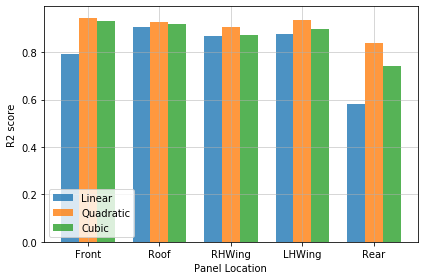

In [12]:
#Use the models to generate predicted values for the Test dataset features
ytest_pred_lr = lr_model.predict(xtest) #predict target values for validation dataset using linear equation model
ytest_pred_quad = quad_model.predict(xtest) #predict target values for validation dataset using quadratic equation model
ytest_pred_cubic = cubic_model.predict(xtest) #predict target values for validation dataset using cubic equation model

#Values cannot be negative
ytest_pred_lr[ytest_pred_lr < 0] = 0
ytest_pred_quad[ytest_pred_quad < 0] = 0
ytest_pred_cubic[ytest_pred_cubic < 0] = 0

#Calculate the score for each model using the Predicted values and the actual test values 
scores_lr = r2_score(ytest,ytest_pred_lr,multioutput='raw_values') #calculate regression score for Validation Data
scores_quad = r2_score(ytest,ytest_pred_quad,multioutput='raw_values') #calculate regression score for Validation Data
scores_cubic = r2_score(ytest,ytest_pred_cubic,multioutput='raw_values') #calculate regression score for Validation Data

#Visualise the results
n_groups=5
bar_width = 0.25
opacity=0.8
index = np.arange(n_groups)

plt.bar(index,scores_lr,bar_width,alpha=opacity,label='Linear')
plt.bar(index+bar_width,scores_quad,bar_width,alpha=opacity,label='Quadratic')
plt.bar(index+2*bar_width,scores_cubic,bar_width,alpha=opacity,label='Cubic')

plt.legend(loc='lower left')
plt.xlabel('Panel Location')
plt.ylabel('R2 score')
plt.xticks(index + bar_width, ('Front', 'Roof', 'RHWing', 'LHWing','Rear'))
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.show()


In [13]:
#Actual scores for the Quadratic Model
print(":: Regression Scores for Validation Data Using Quadratics Eq. Model::")
print("R2 Score for Front Chassis Amps:",scores_quad[0])
print("R2 Score for Roof Edge Amps:",scores_quad[1])
print("R2 Score for RH Wing Mount Amps:",scores_quad[2])
print("R2 Score for LH Wing Mount Amps:",scores_quad[3])
print("R2 Score for Rear Chassis Amps:",scores_quad[4])
print("\n")

:: Regression Scores for Validation Data Using Quadratics Eq. Model::
R2 Score for Front Chassis Amps: 0.9458038445582972
R2 Score for Roof Edge Amps: 0.9265998560219977
R2 Score for RH Wing Mount Amps: 0.90827516485783
R2 Score for LH Wing Mount Amps: 0.9365224904700237
R2 Score for Rear Chassis Amps: 0.8405076511565387




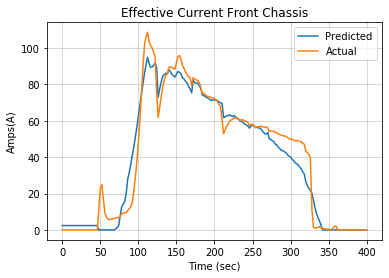

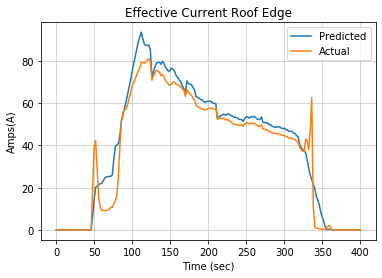

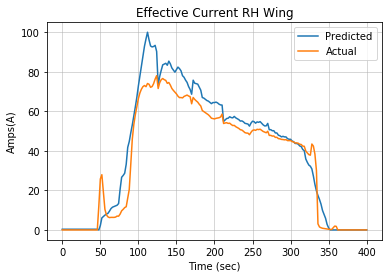

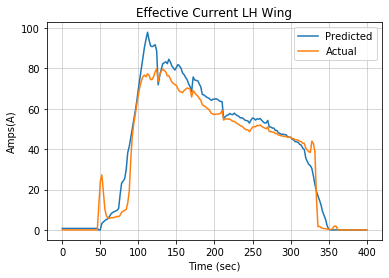

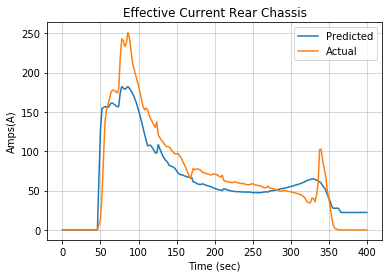

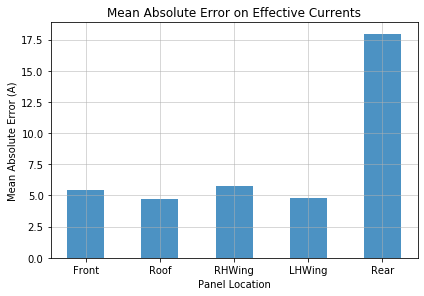

In [14]:
MAE_Amps = [metrics.mean_absolute_error(ytest[:,0],ytest_pred_quad[:,0]),
            metrics.mean_absolute_error(ytest[:,1],ytest_pred_quad[:,1]),
            metrics.mean_absolute_error(ytest[:,2],ytest_pred_quad[:,2]),
            metrics.mean_absolute_error(ytest[:,3],ytest_pred_quad[:,3]),
            metrics.mean_absolute_error(ytest[:,4],ytest_pred_quad[:,4])]

#Visualise Results
plt.plot(time,ytest_pred_quad[:,0],label='Predicted')
plt.plot(time,ytest[:,0],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Current Front Chassis')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Amps(A)')
plt.show()


plt.plot(time,ytest_pred_quad[:,1],label='Predicted')
plt.plot(time,ytest[:,1],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Current Roof Edge')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Amps(A)')
plt.show()

plt.plot(time,ytest_pred_quad[:,2],label='Predicted')
plt.plot(time,ytest[:,2],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Current RH Wing')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Amps(A)')
plt.show()

plt.plot(time,ytest_pred_quad[:,3],label='Predicted')
plt.plot(time,ytest[:,3],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Current LH Wing')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Amps(A)')
plt.show()

plt.plot(time,ytest_pred_quad[:,4],label='Predicted')
plt.plot(time,ytest[:,4],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Current Rear Chassis')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Amps(A)')
plt.show()

n_groups=5
bar_width = 0.5
opacity=0.8
index = np.arange(n_groups)
plt.bar(index,MAE_Amps,bar_width,alpha=opacity)
plt.xlabel('Panel Location')
plt.ylabel('Mean Absolute Error (A)')
plt.xticks(index, ('Front', 'Roof', 'RHWing', 'LHWing','Rear'))
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.title('Mean Absolute Error on Effective Currents')
plt.show()

## Compare Coulombs on Panels & Total Effective Amps

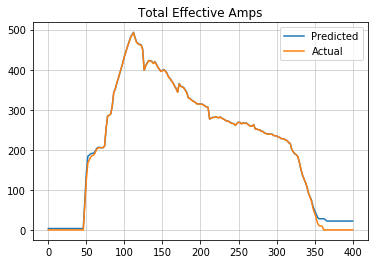

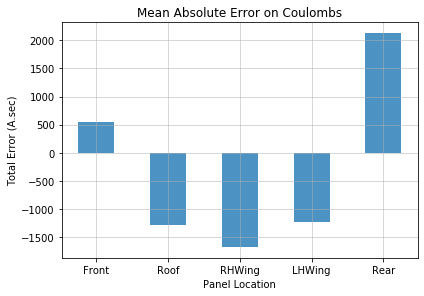

In [15]:
#Convert Predict & Test values to a dataframe
columns = ['Front_A','Roof_A','RHWing_A','LHWing_A','Rear_A']

df_predict = pd.DataFrame(data=ytest_pred_quad,columns=columns,index = range(0,test_time,2))

df_act=pd.DataFrame(data=ytest, columns=columns, index=range(0,test_time,2))

#Calculate Predicted Coulombs on Panels
df_predict['Front_As']=df_predict['Front_A'].mul(2).cumsum()
df_predict['Roof_As']=df_predict['Roof_A'].mul(2).cumsum()
df_predict['RHWing_As']=df_predict['RHWing_A'].mul(2).cumsum()
df_predict['LHWing_As']=df_predict['LHWing_A'].mul(2).cumsum()
df_predict['Rear_As']=df_predict['Rear_A'].mul(2).cumsum()

#Calculate Actual Coulombs on Panels
df_act['Front_As']=df_act['Front_A'].mul(2).cumsum()
df_act['Roof_As']=df_act['Roof_A'].mul(2).cumsum()
df_act['RHWing_As']=df_act['RHWing_A'].mul(2).cumsum()
df_act['LHWing_As']=df_act['LHWing_A'].mul(2).cumsum()
df_act['Rear_As']=df_act['Rear_A'].mul(2).cumsum()

#Calculate total effective amps on the body for predicted and actual values
df_predict['Eff_Amps']= df_predict.apply(lambda row: row.Front_A + row.Roof_A + row.RHWing_A+ 
                                         row.LHWing_A+ row.Rear_A, axis=1)
df_act['Eff_Amps']= df_act.apply(lambda row: row.Front_A + row.Roof_A + row.RHWing_A+ 
                                         row.LHWing_A+ row.Rear_A, axis=1)

errors_coulombs = [df_act.iloc[200,5]-df_predict.iloc[200,5], #Total error for coulombs on Front Chassis
                   df_act.iloc[200,6]-df_predict.iloc[200,6], #Total error for coulombs on Roof Chassis
                   df_act.iloc[200,7]-df_predict.iloc[200,7], #Total error for coulombs on RHWing Chassis
                   df_act.iloc[200,8]-df_predict.iloc[200,8], #Total error for coulombs on LHWing Chassis
                   df_act.iloc[200,9]-df_predict.iloc[200,9]] #Total error for coulombs on Rear Chassis

pct_errors_coulombs = [errors_coulombs[0]*100/df_predict.iloc[200,5], #Percentage Error for coulombs on Front Chassis
                      errors_coulombs[1]*100/df_predict.iloc[200,6], #Percentage Error for coulombs on Roof Chassis
                      errors_coulombs[2]*100/df_predict.iloc[200,7], #Percentage Error for coulombs on RHWing Chassis
                      errors_coulombs[3]*100/df_predict.iloc[200,8], #Percentage Error for coulombs on LHWing Chassis
                      errors_coulombs[4]*100/df_predict.iloc[200,9],] #Percentage Error for coulombs on Rear Chassis

#Visualise the results
plt.plot(df_act.index,df_predict['Eff_Amps'],label='Predicted')
plt.plot(df_act.index,df_act['Eff_Amps'],label='Actual')
plt.legend()
plt.grid(linestyle='-', linewidth=0.5)
plt.title('Total Effective Amps')
plt.show()

n_groups=5
bar_width = 0.5
opacity=0.8
index = np.arange(n_groups)
plt.bar(index,errors_coulombs,bar_width,alpha=opacity)
plt.xlabel('Panel Location')
plt.ylabel('Total Error (A.sec)')
plt.xticks(index, ('Front', 'Roof', 'RHWing', 'LHWing','Rear'))
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.title('Mean Absolute Error on Coulombs')
plt.show()

#print('Predicted:\n',df_predict.head())
#print('Actual:\n',df_act.head())
#print('Total Errors:\n',errors_coulombs)
#print('Percentage Errors:\n',pct_errors_coulombs)

# Validate conversion from Effective Volts to Effective Amps

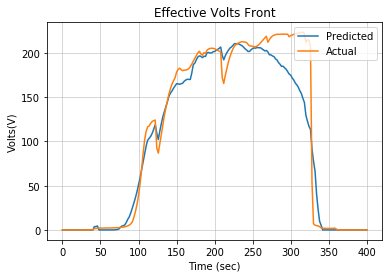

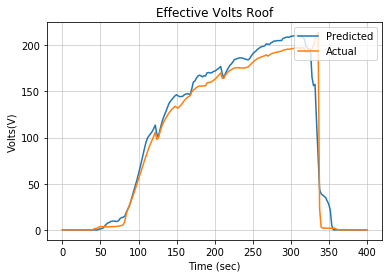

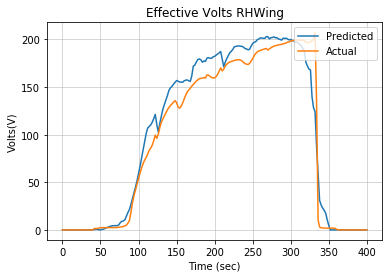

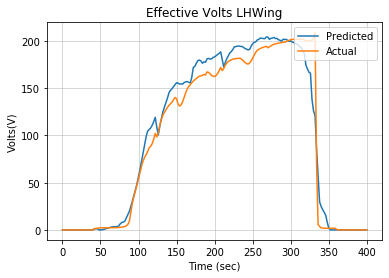

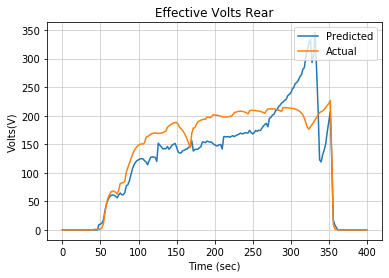

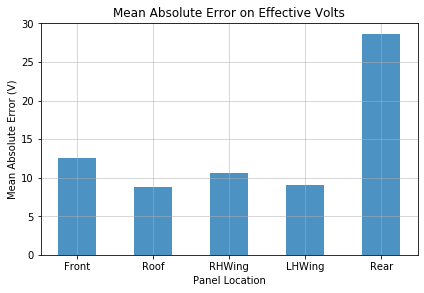

In [16]:
#Calculate the total applied volts from the validation dataset
df_predict['App_Volts']=df_PostSSD.apply(lambda row: row.Front_V + row.Roof_V + row.RHWing_V+ 
                                         row.LHWing_V+ row.Rear_V, axis=1)

df_predict['Front_V']=df_predict.apply(lambda row: (row.App_Volts*row.Front_A)/(row.Eff_Amps+1),axis=1)
df_predict['Roof_V']=df_predict.apply(lambda row: (row.App_Volts*row.Roof_A)/(row.Eff_Amps+1),axis=1)
df_predict['RHWing_V']=df_predict.apply(lambda row: (row.App_Volts*row.RHWing_A)/(row.Eff_Amps+1),axis=1)
df_predict['LHWing_V']=df_predict.apply(lambda row: (row.App_Volts*row.LHWing_A)/(row.Eff_Amps+1),axis=1)
df_predict['Rear_V']=df_predict.apply(lambda row: (row.App_Volts*row.Rear_A)/(row.Eff_Amps+1),axis=1)

MAE_Volts=[metrics.mean_absolute_error(df_PostSSD['Front_V'],df_predict['Front_V']),
           metrics.mean_absolute_error(df_PostSSD['Roof_V'],df_predict['Roof_V']),
           metrics.mean_absolute_error(df_PostSSD['RHWing_V'],df_predict['RHWing_V']),
           metrics.mean_absolute_error(df_PostSSD['LHWing_V'],df_predict['LHWing_V']),
           metrics.mean_absolute_error(df_PostSSD['Rear_V'],df_predict['Rear_V'])]

plt.plot(df_predict.index,df_predict['Front_V'],label='Predicted')
plt.plot(df_predict.index,df_PostSSD['Front_V'],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Volts Front')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Volts(V)')
plt.show()

plt.plot(df_predict.index,df_predict['Roof_V'],label='Predicted')
plt.plot(df_predict.index,df_PostSSD['Roof_V'],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Volts Roof')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Volts(V)')
plt.show()

plt.plot(df_predict.index,df_predict['RHWing_V'],label='Predicted')
plt.plot(df_predict.index,df_PostSSD['RHWing_V'],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Volts RHWing')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Volts(V)')
plt.show()

plt.plot(df_predict.index,df_predict['LHWing_V'],label='Predicted')
plt.plot(df_predict.index,df_PostSSD['LHWing_V'],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Volts LHWing')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Volts(V)')
plt.show()

plt.plot(df_predict.index,df_predict['Rear_V'],label='Predicted')
plt.plot(df_predict.index,df_PostSSD['Rear_V'],label='Actual')
plt.legend(loc='upper right')
plt.title('Effective Volts Rear')
plt.grid(linestyle='-', linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Volts(V)')
plt.show()

n_groups=5
bar_width = 0.5
opacity=0.8
index = np.arange(n_groups)
plt.bar(index,MAE_Volts,bar_width,alpha=opacity)
plt.xlabel('Panel Location')
plt.ylabel('Mean Absolute Error (V)')
plt.xticks(index, ('Front', 'Roof', 'RHWing', 'LHWing','Rear'))
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.title('Mean Absolute Error on Effective Volts')
plt.show()


In [42]:
#Save Model to disk
fileName='ECModel_EffAmps.pkl'
dump(quad_model, fileName) 

#Save Predicted Values to CSV
df_predict.to_csv('predicted_model1A.csv')